<a href="https://colab.research.google.com/github/kartikbatra056/AllAboutTimeSeries/blob/main/ARIMAandFBProphet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Dataset From kaggle

In [3]:
! pip install -q kaggle
! pip install --upgrade statsmodels

     |████████████████████████████████| 9.5MB 3.2MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [4]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d 'rohanrao/nifty50-stock-market-data'

 89% 16.0M/18.0M [00:00<00:00, 48.3MB/s]
100% 18.0M/18.0M [00:00<00:00, 69.2MB/s]


In [1]:
!unzip '/content/nifty50-stock-market-data.zip'

Archive:  /content/nifty50-stock-market-data.zip
  inflating: ADANIPORTS.csv          
  inflating: ASIANPAINT.csv          
  inflating: AXISBANK.csv            
  inflating: BAJAJ-AUTO.csv          
  inflating: BAJAJFINSV.csv          
  inflating: BAJFINANCE.csv          
  inflating: BHARTIARTL.csv          
  inflating: BPCL.csv                
  inflating: BRITANNIA.csv           
  inflating: CIPLA.csv               
  inflating: COALINDIA.csv           
  inflating: DRREDDY.csv             
  inflating: EICHERMOT.csv           
  inflating: GAIL.csv                
  inflating: GRASIM.csv              
  inflating: HCLTECH.csv             
  inflating: HDFC.csv                
  inflating: HDFCBANK.csv            
  inflating: HEROMOTOCO.csv          
  inflating: HINDALCO.csv            
  inflating: HINDUNILVR.csv          
  inflating: ICICIBANK.csv           
  inflating: INDUSINDBK.csv          
  inflating: INFRATEL.csv            
  inflating: INFY.csv                
 

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import warnings
from statsmodels.tsa.api import SimpleExpSmoothing,Holt,ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox as ljung
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import jarque_bera as jb
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

# Exploratory Data analysis 

In [2]:
# Load Reliance dataset
df=pd.read_csv('/content/RELIANCE.csv',parse_dates=['Date'])
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,RELIANCE,EQ,233.05,237.50,251.70,237.50,251.70,251.70,249.37,4456424,1.111319e+14,NaN,NaN,NaN
1,2000-01-04,RELIANCE,EQ,251.70,258.40,271.85,251.30,271.85,271.85,263.52,9487878,2.500222e+14,NaN,NaN,NaN
2,2000-01-05,RELIANCE,EQ,271.85,256.65,287.90,256.65,286.75,282.50,274.79,26833684,7.373697e+14,NaN,NaN,NaN
3,2000-01-06,RELIANCE,EQ,282.50,289.00,300.70,289.00,293.50,294.35,295.45,15682286,4.633254e+14,NaN,NaN,NaN
4,2000-01-07,RELIANCE,EQ,294.35,295.00,317.90,293.00,314.50,314.55,308.91,19870977,6.138388e+14,NaN,NaN,NaN


In [3]:
df.describe(include='all')

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5184,5184,5184,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5184.000000,5.184000e+03,5.184000e+03,2.334000e+03,4.670000e+03,4670.000000
unique,5184,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2007-09-10 00:00:00,RELIANCE,EQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,5184,5184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
first,2000-01-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2020-10-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,987.786950,989.319367,1003.356231,973.918981,987.975174,988.138310,988.720230,5.415171e+06,5.624868e+14,1.350124e+05,2.222530e+06,0.436906
std,NaN,NaN,NaN,556.920215,558.434355,567.971926,546.551339,556.899904,557.018527,557.138677,4.804231e+06,7.660574e+14,1.181286e+05,1.834661e+06,0.145468
min,NaN,NaN,NaN,203.200000,205.500000,219.500000,197.150000,203.300000,203.200000,212.290000,5.282000e+04,4.295543e+12,2.991000e+03,2.909700e+04,0.076300
25%,NaN,NaN,NaN,560.412500,563.137500,572.862500,553.512500,561.325000,561.450000,561.632500,2.813994e+06,2.168086e+14,7.104150e+04,1.177226e+06,0.324050


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5184 entries, 0 to 5183
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                5184 non-null   datetime64[ns]
 1   Symbol              5184 non-null   object        
 2   Series              5184 non-null   object        
 3   Prev Close          5184 non-null   float64       
 4   Open                5184 non-null   float64       
 5   High                5184 non-null   float64       
 6   Low                 5184 non-null   float64       
 7   Last                5184 non-null   float64       
 8   Close               5184 non-null   float64       
 9   VWAP                5184 non-null   float64       
 10  Volume              5184 non-null   int64         
 11  Turnover            5184 non-null   float64       
 12  Trades              2334 non-null   float64       
 13  Deliverable Volume  4670 non-null   float64     

In [5]:
df.set_index(['Date'],inplace=True)
df.sort_index(inplace=True)
df=df.asfreq(freq='B',method='ffill')

In [6]:
# Looking for Duplicates
df.duplicated().sum()
df['Pct_change']=df['VWAP'].pct_change()

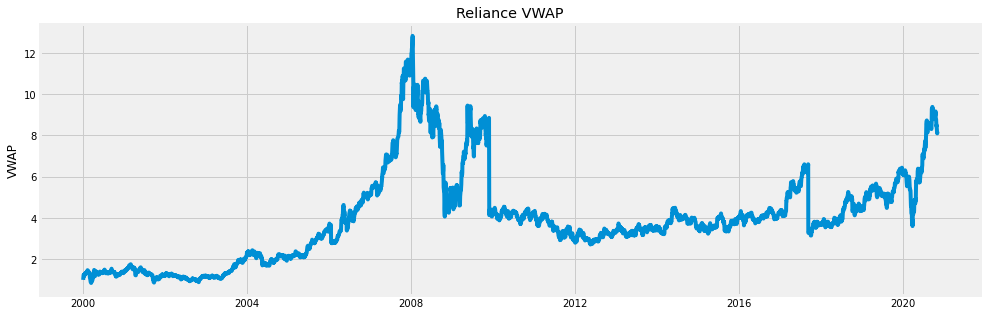

In [7]:
# Visualize VWAP
plt.figure(figsize=(15,5))
plt.plot(df['VWAP']/df['VWAP'][0])
plt.title('Reliance VWAP')
plt.ylabel('VWAP')
plt.show()

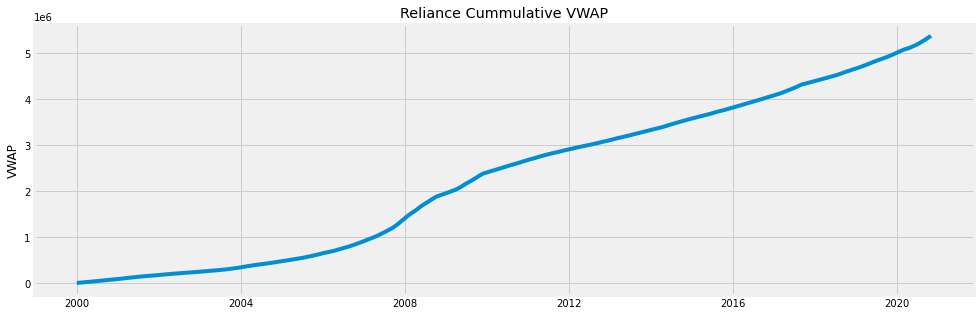

In [8]:
# Visualize Cumsum VWAP
plt.figure(figsize=(15,5))
plt.plot(df['VWAP'].cumsum())
plt.title('Reliance Cummulative VWAP')
plt.ylabel('VWAP')
plt.show()

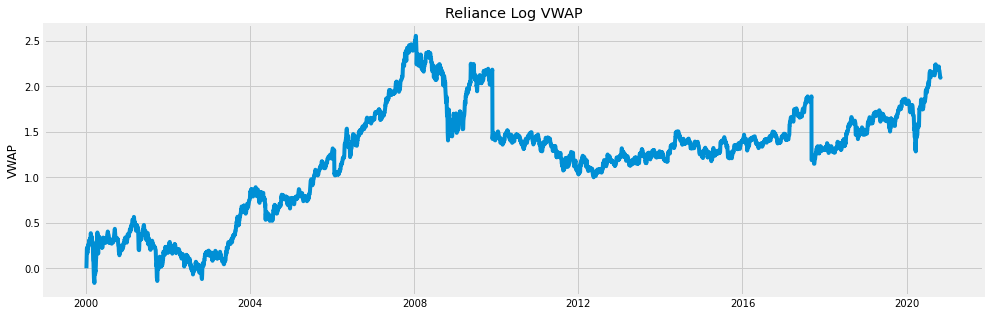

In [9]:
# Visualize Log of VWAP
plt.figure(figsize=(15,5))
plt.plot(np.log(df['VWAP']/df['VWAP'][0]))
plt.title('Reliance Log VWAP')
plt.ylabel('VWAP')
plt.show()

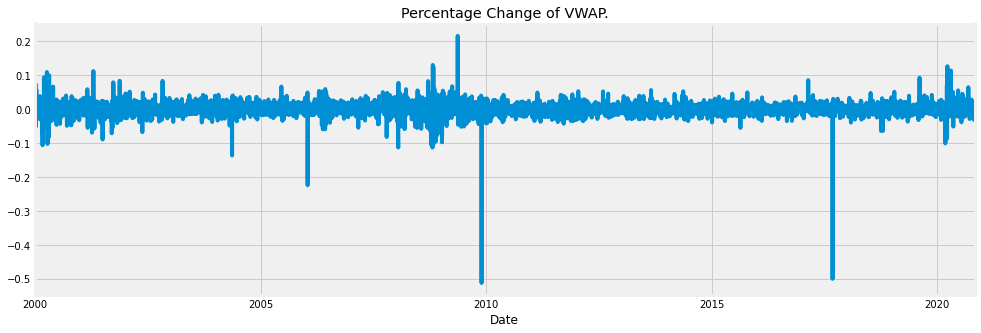

In [10]:

# Visualize Percentage Change of VWAP
plt.figure(figsize=(15,5))
df['Pct_change'].plot()
plt.title('Percentage Change of VWAP.')
plt.show()

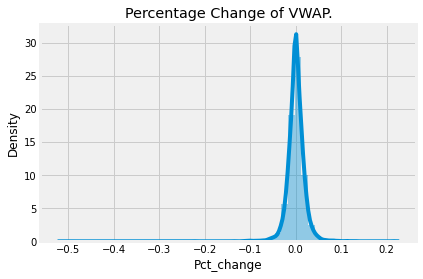

In [11]:
sns.distplot(df['Pct_change'])
plt.title('Percentage Change of VWAP.')
plt.show()

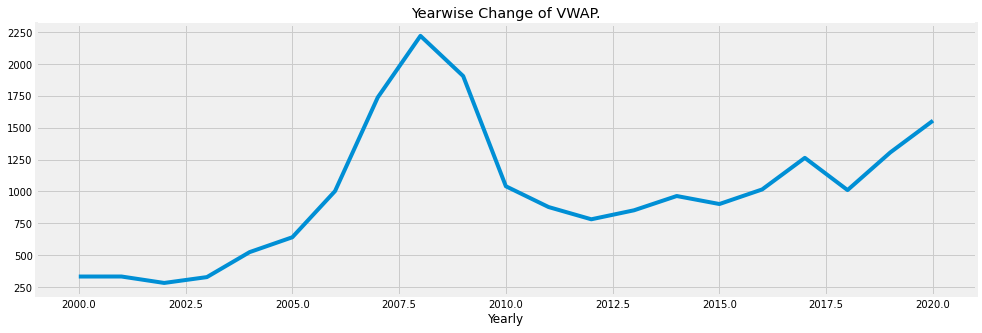

In [12]:
df['Yearly']=df.index.year
mean_year=df.groupby(['Yearly']).median()['VWAP']
plt.figure(figsize=(15,5))
mean_year.plot()
plt.title('Yearwise Change of VWAP.')
plt.show()

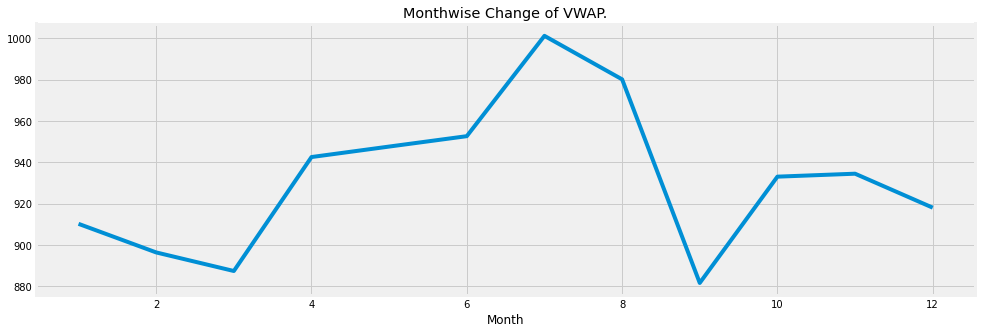

In [13]:
df['Month']=df.index.month
mean_month=df.groupby(['Month']).median()['VWAP']
plt.figure(figsize=(15,5))
mean_month.plot()
plt.title('Monthwise Change of VWAP.')
plt.show()

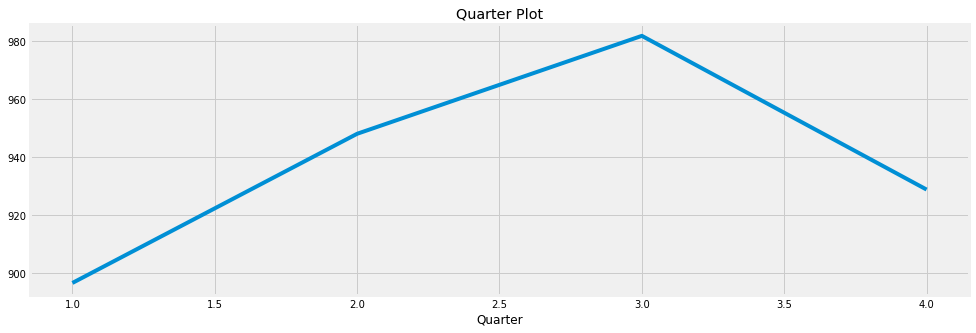

In [14]:
df['Quarter']=df.index.quarter
mean_Quarter=df.groupby(['Quarter']).median()['VWAP']
plt.figure(figsize=(15,5))
mean_Quarter.plot()
plt.title('Quarter Plot')
plt.show()

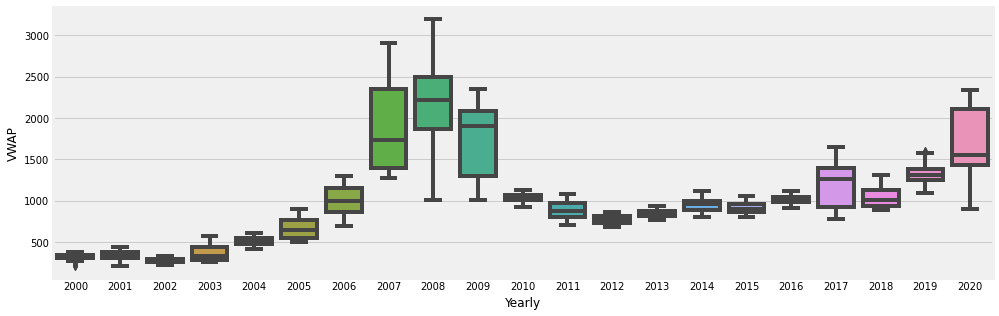

In [15]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df,x='Yearly',y='VWAP')
plt.show()

In [16]:
train_df,test_df=df[:int(df.shape[0]*0.75)],df[-int(df.shape[0]*0.25):]
train_df.shape,test_df.shape

((4076, 18), (1358, 18))

In [17]:
from sklearn.metrics import mean_squared_error
def MAPE(pred,target):
    mape=np.mean(np.abs(target-pred)/target)*100
    return mape

In [19]:
def plot_graph(data,pred,target):
     '''
      Plot input,tagret and prediction
     Parameters: 
        data:input training data
        pred: prediction 
        target: test data
     returns :
          plot graph     
     '''
  
     plt.figure(figsize=(15,5))
     plt.plot(data,label='Train data')
     plt.plot(target.index,pred,label='Prediction')
     plt.plot(target,label='Target')
     plt.title(f'MAPE is :{MAPE(pred,target.values)}')
     plt.legend()
     plt.show()

# Baseline Model

*   Simplest model we can have is taking mean of previous values

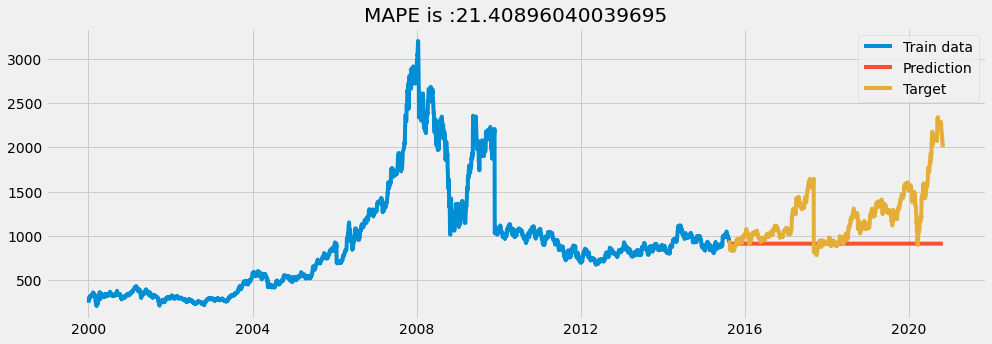

In [20]:
pred=len(test_df)*[np.mean(train_df['VWAP'])]
plot_graph(train_df['VWAP'],pred,test_df['VWAP'])

#### Moving Average Model


In [21]:
def moving_average(data,window=7):
    '''
      plot rolling mean of data alongwith upper and lower limit.
        Parameters:
           data: pandas series to plot
           window: window to take mean
        return :
           plot graph with title as MAPE of model   
    '''

    plt.figure(figsize=(15,7))
    plt.plot(data[window:],label='Series')
    
    mean_df=data.rolling(window=window).mean()
    
    mae=MAPE(mean_df[window:],data[window:])
    
    plt.plot(mean_df[window:],label='Moving average')
    
    deviation=np.std(data[window:]-mean_df[window:])
    upper_limit=mean_df+(mae+2*deviation)
    lower_limit=mean_df-(mae+2*deviation)
    
    plt.plot(upper_limit,'r--',label='Upper limit/lower limit')
    plt.plot(lower_limit,'r--')
    
    plt.xlabel('Date')
    plt.ylabel('VWAP')
    plt.title(f'MAPE is: {mae}')
    plt.show()

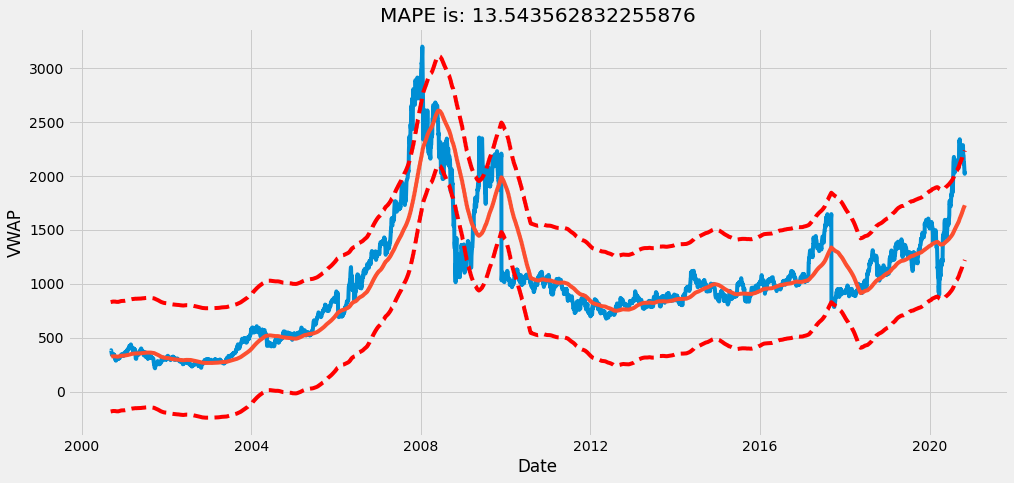

In [22]:
# Moving average with window 180
moving_average(df['VWAP'],window=180)

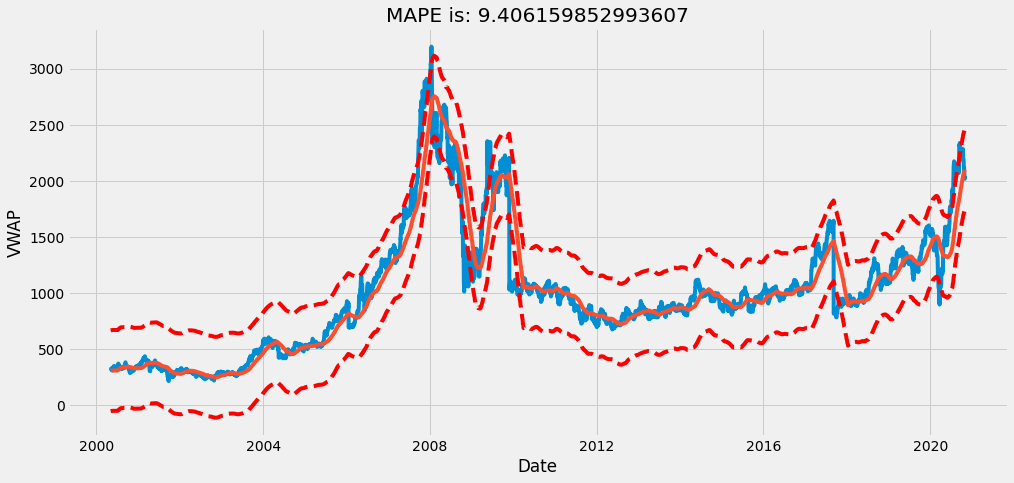

In [23]:
# Moving average with window 90
moving_average(df['VWAP'],window=90)

In [24]:
def SimpleExpSmoothPlot(data,test_data,alpha=.2):
     '''
        plot Simple Exponential Smooth of data alongwith upper and lower limit.
          Parameters:
            data: pandas train_data series to plot
            test_data: pandas test_data series to plot
            alpha: smoothing factor
          return :
            plot graph with title as MAPE of model   
     '''

     plt.figure(figsize=(15,7))
     plt.plot(data.index,data,label='InputSeries')
     
     m=SimpleExpSmoothing(data).fit(smoothing_level=alpha,optimized=False)     
     pred=m.forecast(len(test_data))
     
     plt.plot(test_data,label='Target')
     plt.plot(test_data.index,pred,label='Prediction')
     

     mae=MAPE(pred,test_data.values)
     plt.title(f'MAPE is:{mae}')
     plt.xlabel('Date')
     plt.ylabel('VWAP')
     plt.legend()
     plt.show()

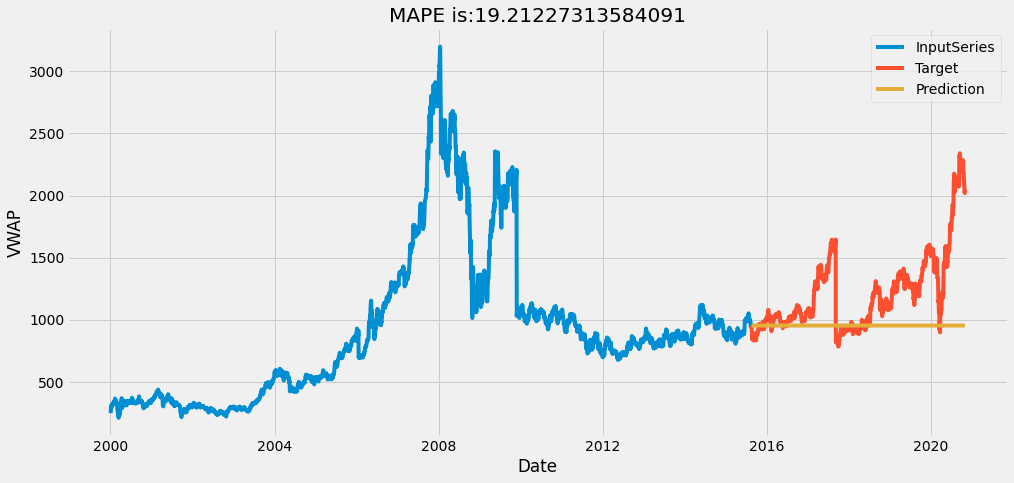

In [25]:
SimpleExpSmoothPlot(train_df['VWAP'],test_df['VWAP'],alpha=.5)

In [26]:
def ExpSmoothPlot(data,test_data,alpha=.2,beta=0.2,exp=False,damp=False,damp_trend=0.5):
     '''
        plot Holt's Exponential Smooth of data alongwith upper and lower limit.
          Parameters:
            data: pandas train_data series to plot
            test_data: pandas test_data series to plot
            alpha: smoothing factor
            beta: smoothing trend
          return :
            plot graph with title as MAPE of model   
     '''
     plt.figure(figsize=(15,7))
     plt.plot(data.index,data,label='InputSeries')
     
     m=Holt(data,exponential=exp, damped_trend=damp).fit(smoothing_level=alpha,smoothing_trend=beta,damping_trend=damp_trend,optimized=False)     
     pred=m.forecast(len(test_data))
     
     plt.plot(test_data,label='Target')
     plt.plot(test_data.index,pred,label='Prediction')
     

     mae=MAPE(pred,test_data.values)
     plt.title(f'MAPE is:{mae}')
     plt.xlabel('Date')
     plt.ylabel('VWAP')
     plt.legend()
     plt.show()

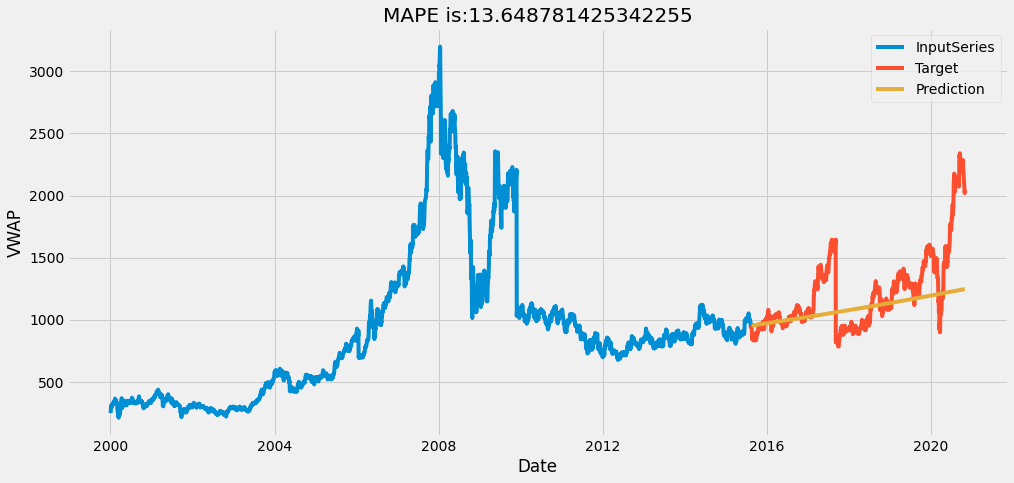

In [27]:
ExpSmoothPlot(train_df['VWAP'],test_df['VWAP'],alpha=.9,beta=0.6,exp=True)

In [28]:
def TripleExpSmoothPlot(data,test_data,alpha=.2,beta=0.2,period=4,season='add',trend='add',transform=False,damp=False):
     '''
        plot Triple Exponential Smooth of data.
          Parameters:
            data: pandas train_data series to plot
            test_data: pandas test_data series to plot
            
          return :
            plot graph with title as MAPE of model   
     '''
     plt.figure(figsize=(15,7))
     plt.plot(data.index,data,label='InputSeries')
     
     m=ExponentialSmoothing(data, seasonal_periods=period, trend=trend, seasonal=season, damped_trend=damp, use_boxcox=transform,initialization_method="estimated").fit()     
     pred=m.forecast(len(test_data))
     
     plt.plot(test_data,label='Target')
     plt.plot(test_data.index,pred,label='Prediction')
     
     mae=MAPE(pred,test_data.values)
     plt.title(f'MAPE is:{mae}')
     plt.xlabel('Date')
     plt.ylabel('VWAP')
     plt.legend()
     plt.show()

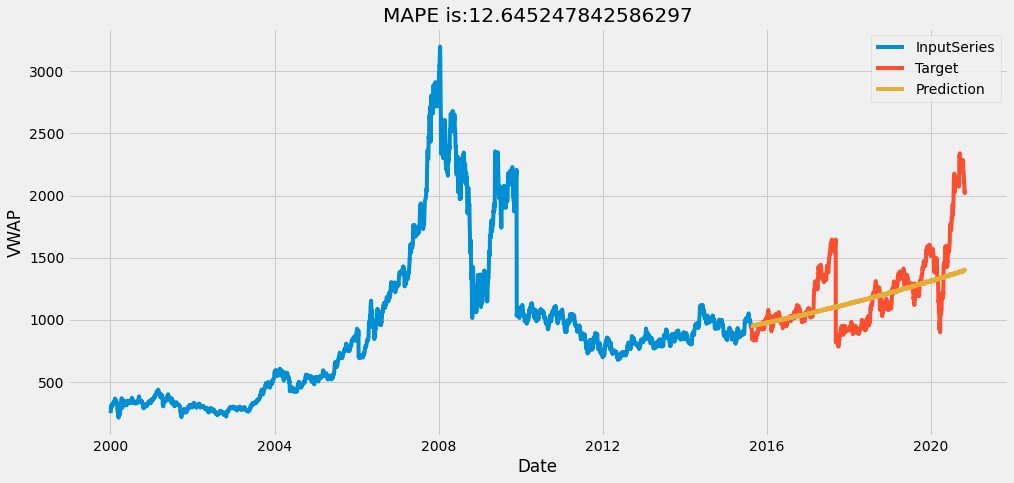

In [29]:
TripleExpSmoothPlot(train_df['VWAP'],test_df['VWAP'],period=30,season='mul',trend='mul',transform=True,damp=False)

# Time Series with ARIMA

<Figure size 864x576 with 0 Axes>

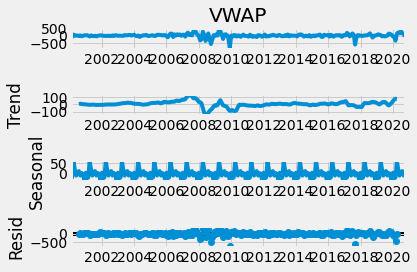

In [30]:
plt.figure(figsize=(12,8))
decompose=seasonal_decompose(df['VWAP'].resample('MS').mean().diff(1).dropna())
decompose.plot();

In [31]:
# Looking for correlation
ljung_p = np.mean(ljung(x=decompose.resid.dropna())[1]).round(3)
print("Ljung Box, p value:", ljung_p, ", Residuals are uncorrelated" if ljung_p>0.05 else ", Residuals are correlated")

Ljung Box, p value: 0.0 , Residuals are correlated


From decomposed we can observe that resid plot shows some pattern which means we will be requiring higher order models

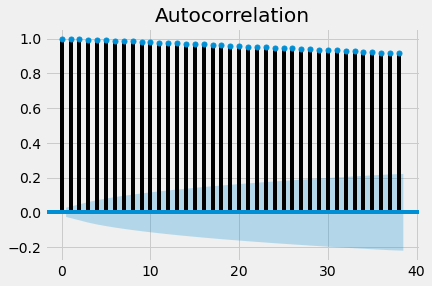

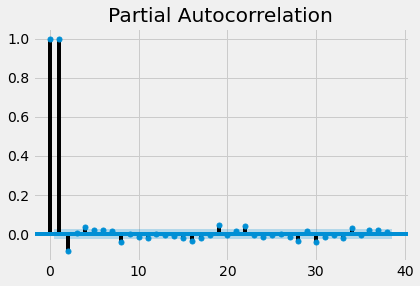

In [32]:
plot_acf(df['VWAP']);
plot_pacf(df['VWAP']);

In [33]:
adf=adfuller(df['VWAP'])[1]
print(f"p-value:{adf.round(4)}","Series is stationary" if adf<0.05 else "Series is Non-stationary")

p-value:0.2594 Series is Non-stationary


#### Above plot shows series is highly correlated.So to overcome this we can try first order differencing.

In [34]:
# first difference
df_diff=df['VWAP'].diff(1).dropna()

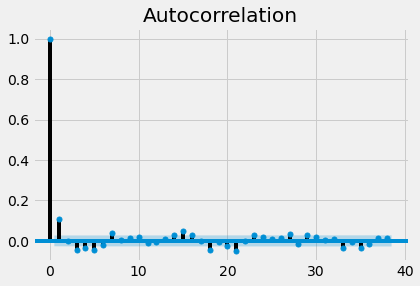

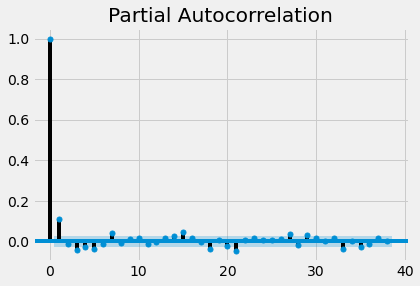

In [35]:
plot_acf(df_diff);
plot_pacf(df_diff);

In [36]:
adf_diff=adfuller(df_diff)[1]
print(f"p-value:{adf_diff.round(4)}","Series is stationary" if adf_diff<0.05 else "Series is Non-stationary")

p-value:0.0 Series is stationary


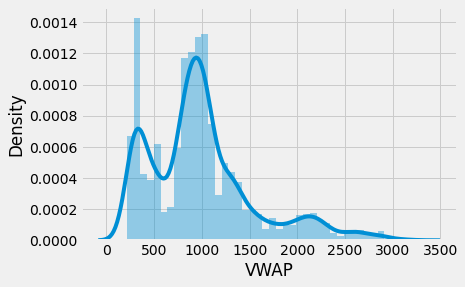

In [37]:
sns.distplot(df['VWAP']);

* Distribution looks bi-modal and skewed  

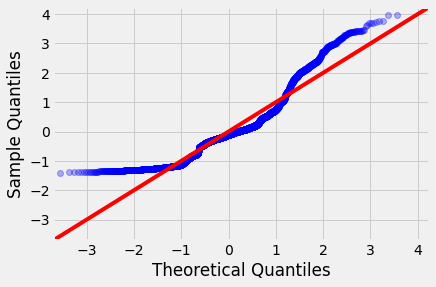

In [38]:
sm.qqplot(df['VWAP'], fit=True, line='45', alpha=0.3);

In [39]:
is_norm=jb(df['VWAP'])[1]
print(f'P-value:{is_norm}','Series is Normal' if is_norm>0.05 else 'Series is Not Normal')

P-value:0.0 Series is Not Normal


In [28]:
def residcheck(residuals, lags):
    """
    Function to check if the residuals are white noise. Ideally the residuals should be uncorrelated, zero mean, 
    constant variance and normally distributed. First two are must, while last two are good to have. 
    If the first two are not met, we have not fully captured the information from the data for prediction. 
    Consider different model and/or add exogenous variable. 
    
    If Ljung Box test shows p> 0.05, the residuals as a group are white noise. Some lags might still be significant. 
    
    Lags should be min(2*seasonal_period, T/5)
    
    plots from: https://tomaugspurger.github.io/modern-7-timeseries.html
    
    """
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(ljung(x=residuals, lags=lags)[1])
    norm_p_val =  jb(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
    
    
    
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));

    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    
    print("** Mean of the residuals: ", np.around(resid_mean,2))
    
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
    
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3), "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
    
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    
    return ts_ax, acf_ax, kde_ax

In [41]:
from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(train_df['VWAP'].resample('MS').mean(),(2,1,2)) 
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.VWAP   No. Observations:                  187
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1147.364
Method:                       css-mle   S.D. of innovations            111.737
Date:                Sat, 07 Nov 2020   AIC                           2306.728
Time:                        08:36:29   BIC                           2326.115
Sample:                    02-01-2000   HQIC                          2314.584
                         - 08-01-2015                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.5780     10.254      0.349      0.727     -16.520      23.676
ar.L1.D.VWAP    -0.0668      0.317     -0.211      0.833      -0.688       0.555
ar.L2.D.VWAP    -0.3119      0.244     -1.279      0.201      -0.790       0.166
ma.L1.D.VWAP     0.4457      0.324      1.377      0.168      -0.189       1.080
ma.L2.D.VWAP     0.2853      0.236      1.208      0.227      -0.178       0.748
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.1071           -1.7875j            1.7907           -0.2595
AR.2           -0.1071           +1.7875j            1.7907            0.2595
MA.1           -0.7812           -1.7016j            1.8723           -0.3185
MA.2           -0.7812           +1.7016j            1.8723            0.3185
-----------------------------------------------------------------------------
"""

** Mean of the residuals:  -0.12

** Ljung Box Test, p-value: 0.37 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


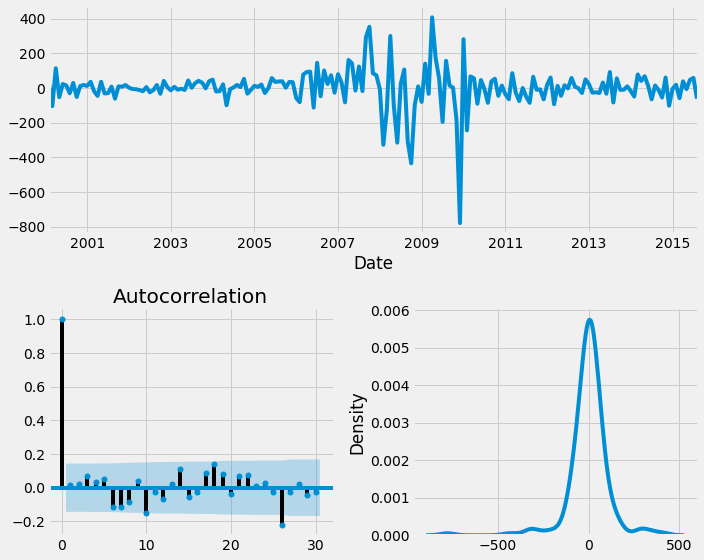

In [42]:
residcheck(model_fit.resid, lags=30);

In [43]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 3.5MB/s 
     |████████████████████████████████| 2.1MB 20.3MB/s 
     |████████████████████████████████| 808kB 41.9MB/s 
     |████████████████████████████████| 8.7MB 39.5MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: setuptools 50.3.2
    Uninstalling setuptools-50.3.2:
      Successfully uninstalled setuptools-50.3.2
  Found existing installation: statsmodels 0.12.1
    Uninstalling statsmodels-0.12.1:
      Successfully uninstalled statsmodels-0.12.1


In [18]:
from pmdarima import auto_arima
auto_arima(train_df['VWAP'].resample('MS').mean(),seasonal=True,m=12,d=1,information_criterion='aicc').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  188
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1148.179
Date:                Sat, 07 Nov 2020   AIC                           2300.359
Time:                        08:38:02   BIC                           2306.821
Sample:                             0   HQIC                          2302.977
                                - 188                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4003      0.037     10.936      0.000       0.329       0.472
sigma2       1.26e+04    516.886     24.373      0.000    1.16e+04    1.36e+04
===================================================================================
Ljung-Box (Q):                       48.35   Jarque-Bera (JB):              1627.59
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               2.02   Skew:                            -1.71
Prob(H) (two-sided):                  0.01   Kurtosis:                        17.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

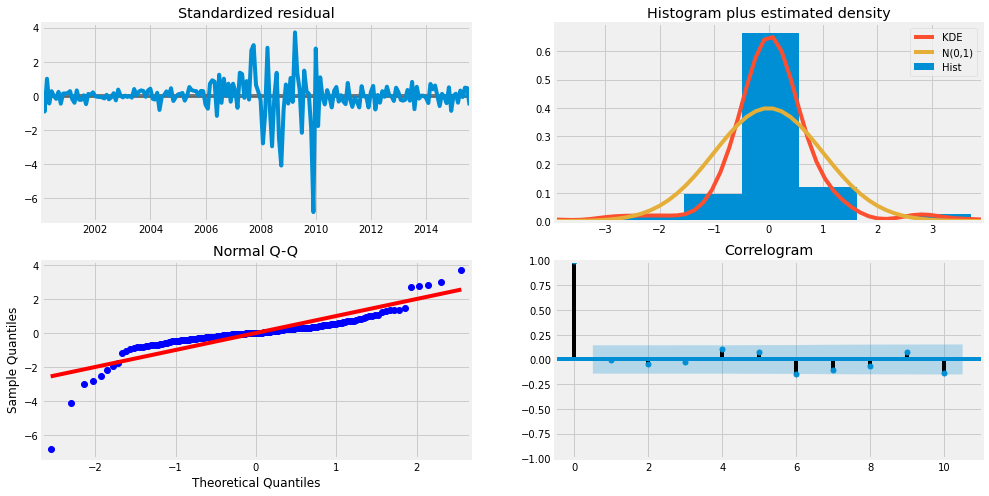

In [19]:
sarima_model=(SARIMAX(endog=train_df["VWAP"].resample('MS').mean(), 
               order=(0,1,1),
               trend='c',
               enforce_invertibility=False))

sarima_fit=sarima_model.fit()

start = len(train_df.resample('MS').mean())
end = len(train_df.resample('MS').mean()) +len(test_df.resample('MS').mean()) -1

sarima_fitted = sarima_fit.fittedvalues

sarima_resid = sarima_fit.resid

py_sarima = sarima_fit.predict(start, end, dynamic=False)

sarima_fit.plot_diagnostics(figsize=(15,8));

In [20]:
! pip install fbprophet

In [21]:
from fbprophet import Prophet
train_df.reset_index(inplace=True)
train_df.rename(columns={'Date':'ds','VWAP':'y','High':'cap','Low':'floor'},inplace=True)
test_df.reset_index(inplace=True)
test_df.rename(columns={'Date':'ds','VWAP':'y','High':'cap','Low':'floor'},inplace=True)

In [104]:
train_fb=train_df[['ds','y','cap','floor']]
test_fb=test_df[['ds','y','cap','floor']]

In [131]:
fb_model=Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=False,uncertainty_samples=300)

fb_model.add_seasonality('self_define_cycle',period=12,fourier_order=8,mode='multiplicative')

fb_model.fit(train_fb)

fb_df=fb_model.make_future_dataframe(len(test_fb),freq='B')

fb_df_pred=fb_model.predict(fb_df)[['ds','yhat']]

fb_df_full=fb_model.predict(fb_df)

fb_resid=train_fb['y'].values-fb_df_pred['yhat'].iloc[:len(train_fb)]

fb_forecast=fb_df_pred[-len(test_fb):]

MAPE(fb_forecast['yhat'].values,test_fb['y'].values)

13.499073828322866

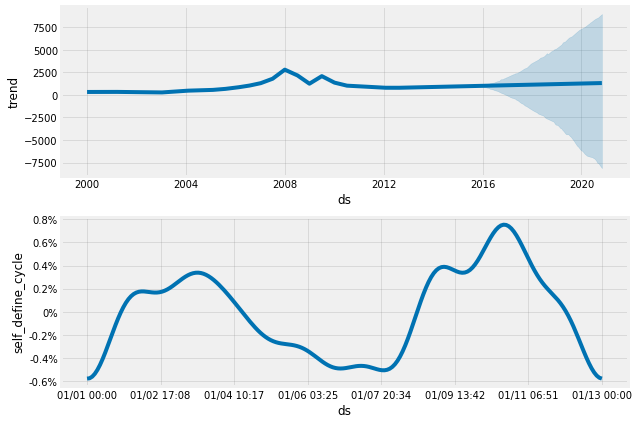

In [132]:
fb_model.plot_components(fb_df_full);

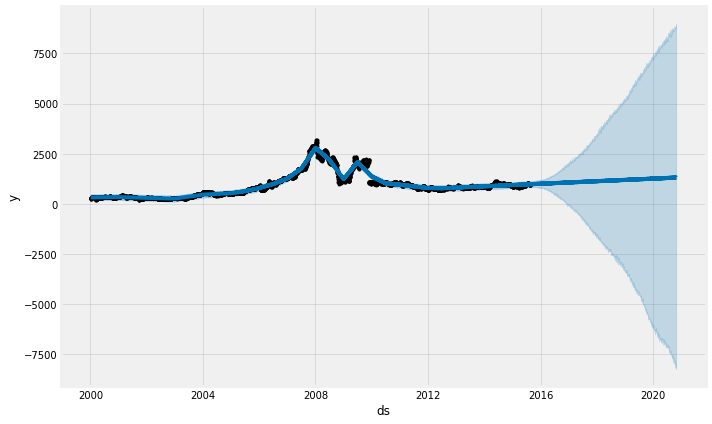

In [133]:
fb_model.plot(fb_df_full);

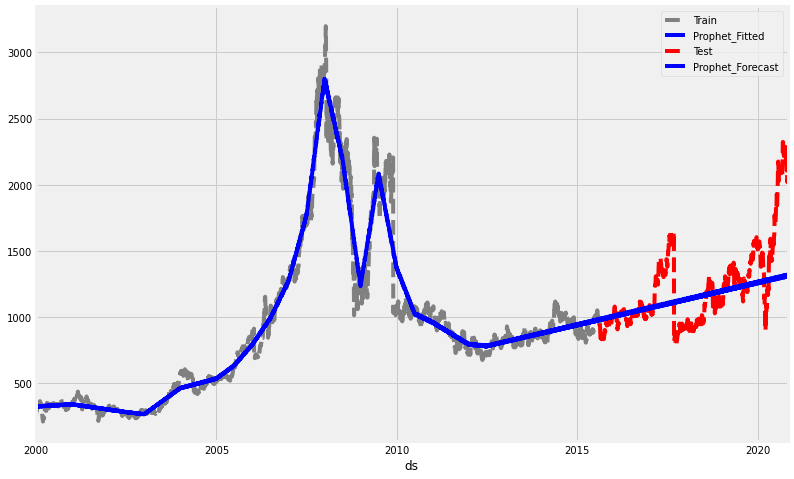

In [134]:
train_fb.set_index('ds')['y'].plot(figsize=(12,8), style="--", color="gray", legend=True, label="Train")

fb_df_pred.set_index('ds')['yhat'].iloc[:-len(test_df)].plot(color="b", legend=True, label="Prophet_Fitted")

test_fb.set_index('ds')['y'].plot(style="--",color="r", legend=True, label="Test")

fb_df_pred.set_index('ds')['yhat'].iloc[-len(test_df):].plot(color="b", legend=True, label="Prophet_Forecast");

** Mean of the residuals:  0.0

** Ljung Box Test, p-value: 0.0 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


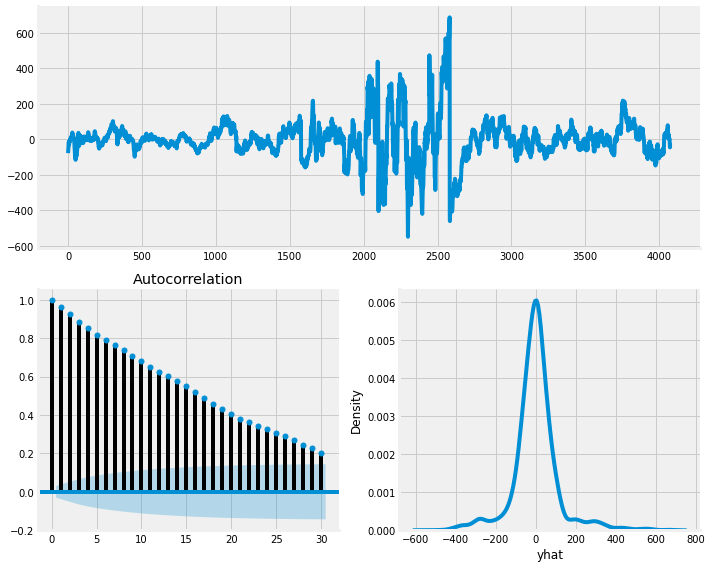

In [135]:
residcheck(fb_resid,30);